Spectroscopic data reduction in six simple steps. The steps performed in this notebook are shown in **bold.**

Step 1: Trim and subtract bias from all the data.

Step 2: Flatfield the data.

Step 3: Construct a comparison lamp image from separate He and Ne lamps.

Step 4: Fit a wavelength solution to the center of the lamp composite. 

Step 5: Extract the 1-D spectrum and its wavelength solution.

Step 6: Apply a relative flux calibration.

**$\rightarrow$ now you are ready to do a bit of analysis.**

Piece of cake. 

In [1]:
# start by importing the essentials 
import numpy as np 
from matplotlib import pyplot as plt 

from astropy import units as u
from astropy import constants as c
from astropy.io import fits
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from astropy.modeling.polynomial import Polynomial1D
from astropy.io import ascii
from astropy.table import Table

from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils.analysis import line_flux, centroid, equivalent_width
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi

import astropy.coordinates as coord
from astropy.time import Time

# (0) Read in the data

### Calibrated data: 

In [2]:
path = '/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/sandbox/'
spec = np.load(path+'betacmi_spec.npy') * u.count 
wave = np.load(path+'wave_sol.npy') * u.AA

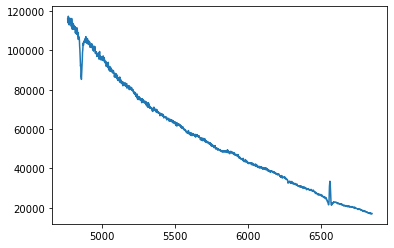

In [3]:
plt.plot(wave, spec)

# (8) Do some analysis 

Specutils is an astropy package designed for the analysis spectra. For more information about is capabilities, because sure to check out the documentation: 

https://specutils.readthedocs.io/en/stable/index.html

To start, make a spectrum object. Notice that we added units when we read the arrays in - the input for Spectrum1D must a Quantity which is value with an associated unit (see the documentation for more information: https://docs.astropy.org/en/stable/units/quantity.html). 

In [4]:
spectrum = Spectrum1D(flux=spec, spectral_axis=wave)

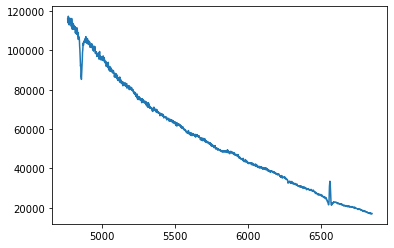

In [5]:
plt.plot(spectrum.spectral_axis, spectrum.flux)

Notice that the 'flux' is in whatever units that were input to the Spectrum1D function. In this case, its counts. If you forget, you can always check the associated units. 

In [6]:
spectrum.unit

Unit("ct")

In [7]:
spectrum.wavelength.unit

Unit("Angstrom")

### Fit the continuum. 

We can start with simple continuum fitting using built-in functions in specutils. The first option is simple - fit a model to the entire spectrum. 

In [8]:
cont = fit_generic_continuum(spectrum)

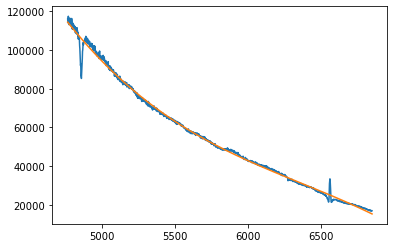

In [9]:
plt.plot(spectrum.wavelength, spectrum.flux)
plt.plot(spectrum.wavelength, cont(spectrum.wavelength))

This already looks pretty good, but notice that the fit gets worse close to the emission and absorption lines. Try excluding regions of the spectrum around these lines to see if it improves the fit. 

How do you decide which portion of the spectrum to exclude? The idea is to make sure no portion of the line (the core or wings of the line) contribute to the continuum fit. Try zooming in on a portion of the spectrum around the lines to identify a first guess by eye. Play around with different window sizes to see how it affects the fit. 

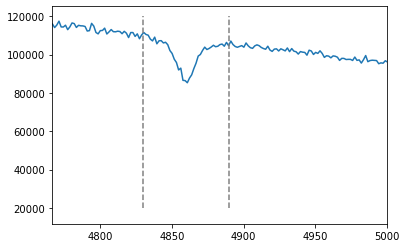

In [10]:
plt.plot(spectrum.wavelength, spectrum.flux)
plt.xlim(spectrum.wavelength.min().value,5000)

plt.plot([4830,4830], [20000,120000], color='gray', linestyle='dashed')
plt.plot([4890,4890], [20000,120000], color='gray', linestyle='dashed')

In [11]:
# regions to keep 
regions = [(spectrum.wavelength.min(), 4830.*u.AA), (4890.*u.AA, 6525.*u.AA), (6600.*u.AA, spectrum.wavelength.max()-1*u.AA)]

fit_cont = fit_continuum(spectrum, window=regions)

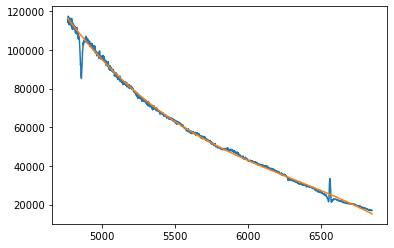

In [12]:
plt.plot(wave, spectrum.flux)
plt.plot(wave, fit_cont(wave))

This looks better on the blue end - notice that the fit line now sits on the continuum, not slightly below it. This is not the case on the red end. To analyze this emission line - H$\alpha$ - you will likely find a better continuum fit using a small portion of the spectrum around the line. 

(15000.0, 40000.0)

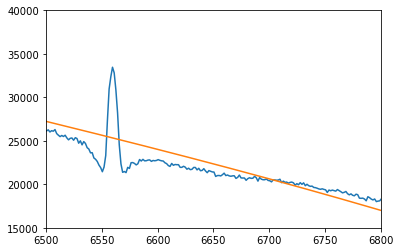

In [13]:
# zoom in on the H-alpha line to see the discrepancy with the continuum fit 
plt.plot(wave, spectrum.flux)
plt.plot(wave, fit_cont(wave))
plt.xlim(6500,6800)
plt.ylim(15000,40000)

In [14]:
# extract a small portion of the spectrum around the H-alpha line
halpha_slice = spectrum[6400.*u.AA:6700.*u.AA]

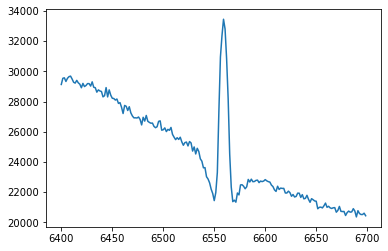

In [15]:
plt.plot(halpha_slice.wavelength, halpha_slice.flux)

In [16]:
# fit the continuum in this spectral region, excluding the line itself 
fit_halpha_cont = fit_continuum(halpha_slice, window=[(halpha_slice.wavelength.min(), 6525.*u.AA),(6600.*u.AA,halpha_slice.wavelength.max())])

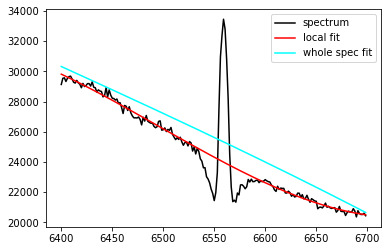

In [17]:
plt.plot(halpha_slice.wavelength, halpha_slice.flux, color='black')
plt.plot(halpha_slice.wavelength, fit_halpha_cont(halpha_slice.wavelength), color='red')
plt.plot(halpha_slice.wavelength, fit_cont(halpha_slice.wavelength), color='cyan')
plt.legend(['spectrum', 'local fit', 'whole spec fit'])

Use this improved continuum fit to get the continuum-normalized spectrum. 

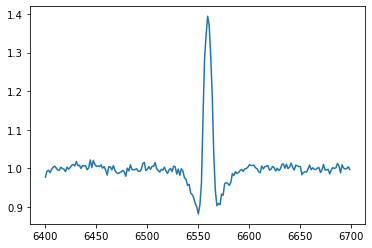

In [18]:
norm_halpha_spec = halpha_slice.flux / fit_halpha_cont(halpha_slice.wavelength)

plt.plot(halpha_slice.wavelength, norm_halpha_spec)

Notice that if we do the same for the whole spectrum, the poor continuum fit on the red end of the spectrum becomes very apparent. 

Try playing around with different spectral regions used in the continuum fit to see if you can get a good model for the whole spectrum at once. 

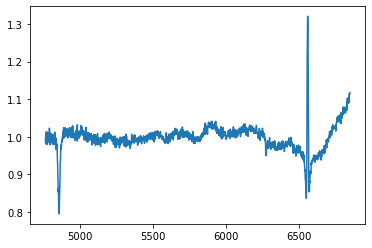

In [19]:
norm_spec = spectrum / fit_cont(spectrum.wavelength)

plt.plot(norm_spec.wavelength, norm_spec.flux)

### Find the line centroid. 

Compute the line centroid for any emission and absorption lines in your spectrum and compare the wavelength to the known wavelength of famous emission lines. For example, this spectrum of Beta CMi has a prominent H$\beta$ absorption feature and a strong H$\alpha$ emission line. 

In [20]:
centroid(spectrum, SpectralRegion(6500.*u.AA, 6600.*u.AA))

<Quantity 6548.53220422 Angstrom>

Notice that we don't quite get the right answer if we feed in too broad a region of the spectrum. Why not? Take a look at the spectrum. 

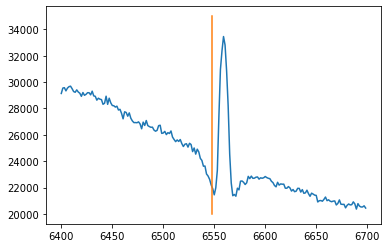

In [21]:
plt.plot(halpha_slice.wavelength, halpha_slice.flux)
plt.plot([6548.5322,6548.5322],[20000,35000])

Notice that there is a significant tilt to the continuum that means there is more signal in the blue than the red. There are two things we can do to improve the result. 

(1) use a smaller window around the line: 

In [22]:
centroid(spectrum, SpectralRegion(6525.*u.AA, 6600.*u.AA))

<Quantity 6561.86628782 Angstrom>

and 

(2) use the continuum-normalized spectrum:

In [23]:
halpha_center = centroid(halpha_slice/fit_halpha_cont(halpha_slice.wavelength), SpectralRegion(6525.*u.AA, 6600.*u.AA))
halpha_center

<Quantity 6562.52345851 Angstrom>

Compare this to the known wavelength of H$\alpha$. You can do the same for the H$\beta$ absorption line. 

In [24]:
centroid(spectrum, SpectralRegion(4830.*u.AA, 4890.*u.AA))

<Quantity 4859.72401257 Angstrom>

### Measure the linewidths.

Stars of different spectral type will have different linewidths. Specutils has a few different tools to measure the linewidth - some assume that the line profile is approximately Gaussian, some do not. Compare a few different measurements for at least one line in your spectrum. 

In [25]:
gsw = gaussian_sigma_width(halpha_slice, regions=SpectralRegion(6525.*u.AA, 6600.*u.AA)) 
gsw

<Quantity 21.15775838 Angstrom>

In [26]:
gf = gaussian_fwhm(halpha_slice, regions=SpectralRegion(6525.*u.AA, 6600.*u.AA)) 
gf

<Quantity 49.82271354 Angstrom>

In [27]:
fwhm = fwhm(halpha_slice, regions=SpectralRegion(6525.*u.AA, 6600.*u.AA)) 
fwhm

<Quantity 72.74112858 Angstrom>

In [28]:
fwzi = fwzi(halpha_slice, regions=SpectralRegion(6525.*u.AA, 6600.*u.AA)) 
fwzi

<Quantity 11.93008923 Angstrom>

Text(0, 0.5, 'normalized flux')

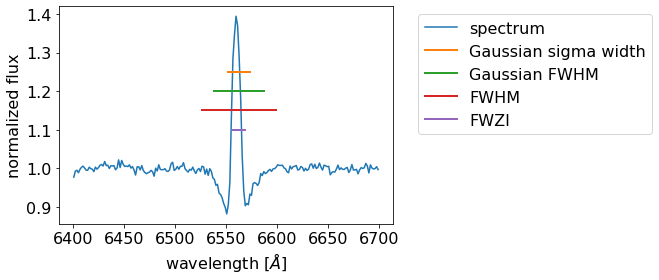

In [29]:
# plot the results on the line profile 
plt.plot(halpha_slice.wavelength, halpha_slice.flux/fit_halpha_cont(halpha_slice.wavelength))

plt.plot([(halpha_center.value-gsw.value/2.), (halpha_center.value+gsw.value/2.)], [1.25,1.25], lw=2)
plt.plot([(halpha_center.value-gf.value/2.), (halpha_center.value+gf.value/2.)], [1.2,1.2], lw=2)
plt.plot([(halpha_center.value-fwhm.value/2.), (halpha_center.value+fwhm.value/2.)], [1.15,1.15], lw=2)
plt.plot([(halpha_center.value-fwzi.value/2.), (halpha_center.value+fwzi.value/2.)], [1.1,1.1], lw=2)

# add a plot legend
# place it outside the plot and use fonts large enough to read
plt.legend(['spectrum', 'Gaussian sigma width', 'Gaussian FWHM', 'FWHM', 'FWZI'], fontsize=16, bbox_to_anchor=(1.05,1))

# clean up the axis labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel('wavelength [$\AA$]', fontsize=16)
plt.ylabel('normalized flux', fontsize=16)

Which approach best represents the width of the H$\alpha$ line in this case? The H$\beta$ line? 

### Measure the line flux.

The flux of an emission line is the amount of signal above the continuum. For this reason, specutils assumes that the spectrum has already been continuum-subtracted for line flux measurements. 

In [30]:
# subtract the continuum using the fit derived above
halpha_cont_sub = halpha_slice - fit_halpha_cont(halpha_slice.wavelength)

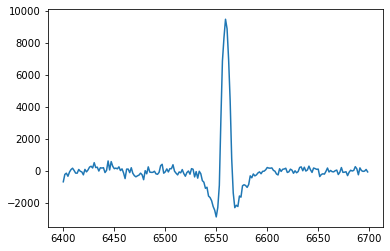

In [31]:
# check to make sure the continuum subtraction looks good 
plt.plot(halpha_cont_sub.wavelength, halpha_cont_sub.flux)

In [32]:
# try different window sizes to see how they affect the line flux 
line_flux(halpha_cont_sub, SpectralRegion(6525*u.AA, 6600*u.AA))

<Quantity 16577.53544243 Angstrom ct>

### Measure the equivalent width.

The equivalent width is a measure of the absorption relative to the continuum level. Specutils expects a normlized spectrum which we can give using the continuum fit derived above. 

(4750.0, 5000.0)

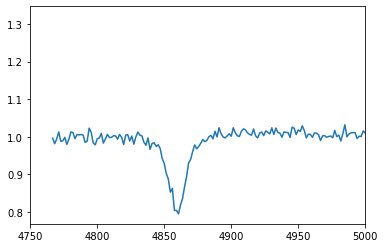

In [33]:
# plot the normalized spectrum
plt.plot(norm_spec.wavelength, norm_spec.flux)
# zoom in on the H-beta absorption line 
plt.xlim(4750,5000)

In [34]:
equivalent_width(norm_spec, regions=SpectralRegion(4830*u.AA, 4890*u.AA)) 

<Quantity 3.40791267 Angstrom>

Try playing around with different region sizes to see how this changes the computed equivalent width. 